<a href="https://colab.research.google.com/github/ucfilho/marquesgabi_paper_fev_2021/blob/main/CNN_classify_grain_feb_15_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import zipfile
import numpy as np
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split

In [ ]:
# https://www.kaggle.com/ppsheth91/92-5-accuracy-with-keras-tuner-fashionmnist-cnn

In [2]:
!pip install visualkeras

In [3]:
import os
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras.layers.core import Dense,Activation,Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import visualkeras
from keras.utils import plot_model
import math
from keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [4]:
!git clone https://github.com/marquesgabi/Doutorado
%cd Doutorado
Transfere='FotosTreino882_and_Segm.zip'
file_name = zipfile.ZipFile(Transfere, 'r')
file_name.extractall()

fatal: destination path 'Doutorado' already exists and is not an empty directory.
/content/Doutorado


In [5]:
# y_pred,confusion_matrix,METRICS=AnnGrain(ANN_dat,df.drop('Width',axis=1))
# def AnnGrain(df,df_class):
def AnnGrain(df):
  y_valor=df['Type']

  quantidade= df.groupby('Type').size()

  df_G = df[df["Type"] == "G"] 
  Cut=['Unnamed: 0','Type','Width']
  FotosG= df_G.drop(Cut,axis=1)


  Size=28
  img_G=[]

  Num,cols=FotosG.shape
  for i in range(Num):
    data=np.array(FotosG.iloc[i]).reshape(Size,Size)
    img = Image.fromarray(data.astype('uint8'), mode='L')
    img=np.float32(img)
    img28=cv2.resize(img,(Size,Size), interpolation = cv2.INTER_AREA)
    img_G.append(img28)

  df_Z = df[df["Type"] == "Z"] 
  Cut=['Unnamed: 0','Type','Width']
  FotosZ= df_Z.drop(Cut,axis=1)

  # We'll choose which is grain and withdraw from 750 segmented photos

  Size=28
  img_Z=[]

  Num,cols=FotosZ.shape
  for i in range(Num):
    data=np.array(FotosZ.iloc[i]).reshape(Size,Size)
    img = Image.fromarray(data.astype('uint8'), mode='L')
    img=np.float32(img)
    img28=cv2.resize(img,(Size,Size), interpolation = cv2.INTER_AREA)
    img_Z.append(img28)

  GRAO=[0,146,149,166,217,222,223,257,268,286,455,482,538,612,644,647,651,677] # 0 ate 749
  GRAO=np.array(GRAO)
  Ind=FotosZ.index
  FotosNG=FotosZ.copy()
  for i in GRAO:
    FotosNG=FotosNG.drop(Ind[i])

  PERCENT=245.0/(len(FotosNG.index))
  FotosNG=FotosNG.sample(frac=PERCENT, replace=True)

  rows,col=FotosG.shape
  y_total=[] # grao-->zero, nao grao-->1
  for i in range(rows):
    y_total.append(0) #  # grao-->zero
  for i in range(rows,(2*rows)):
    y_total.append(1) #  # nao grao-->zero

  frames = [FotosG,FotosNG]
  result = pd.concat(frames)

  #Define data train and data test

  W_train, W_test, yw_train, yw_test = train_test_split(np.array(result), np.array(y_total), 
                                                      test_size=0.30, shuffle=True, 
                                                      random_state=42)

  train_images=W_train #imagens utilizadas para o treino
  train_labels=yw_train # resposta esperada para o treino
  test_images=W_test
  test_labels=yw_test

  return W_train, W_test, yw_train, yw_test

In [6]:
!git clone https://github.com/marquesgabi/Doutorado
%cd Doutorado
Transfere='FotosTreino882_and_Segm.zip'
file_name = zipfile.ZipFile(Transfere, 'r')
file_name.extractall()

"""# First step: get the segmented file (photos stored in csv file)"""

labels = [] #name files

with zipfile.ZipFile(Transfere, "r") as f:
  for f in f.namelist():
    labels.append(f)

Num=len(labels)
ANN_dat=pd.read_csv(labels[0])
for i in range(1,Num):
  df_new=pd.read_csv(labels[i])
  df_new = df_new[~df_new['Type'].isin(['G'])] # drop grain row which is not in 882
  frames = [ANN_dat, df_new]
  ANN_dat= pd.concat(frames, ignore_index=True)

fatal: destination path 'Doutorado' already exists and is not an empty directory.
/content/Doutorado/Doutorado


In [7]:
#W_train, W_test, yw_train, yw_test =AnnGrain(ANN_dat)
X_train,X_val, Y_train, Y_val =AnnGrain(ANN_dat)

In [8]:
# Building the basic CNN Model without tuning any hyper parameters #

model = tf.keras.Sequential()

# First layer, which has a 2D Convolutional layer with kernel size as 3*3, Relu activation & Max pooling operation 
model.add(Conv2D(32, (3,3), padding='same', input_shape=(28,28,1),activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second layer, which has a 2D Convolutional layer with kernel size as 3*3, ReLU activation and Max pooling operation 
model.add(Conv2D(64, (3,3), padding='same', activation=tf.nn.relu))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Fully connected layer with ReLU activation function 
model.add(Flatten())
model.add(Dense(128, activation=tf.nn.relu))
# Output layer with softmax activation function
model.add(Dense(1, activation=tf.nn.softmax))

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1

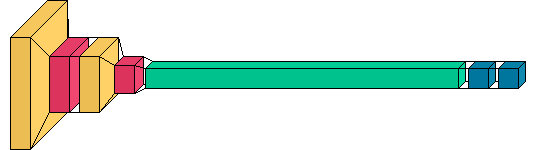

In [10]:
visualkeras.layered_view(model)

In [11]:
# Optimizer specified here is adam, loss is categorical crossentrophy and metric is accuracy
model.compile(optimizer='adam',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [12]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_val, Y_val))

model.fit(train_data, epochs=128, validation_data=valid_data)

Epoch 1/128


ValueError: ignored

In [ ]:
'''
train_model = model.fit(X_train, Y_train,
                  batch_size=128,
                  epochs=50,
                  verbose=1,
                  validation_data=(X_val, Y_val))
'''